In [ ]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
import xlsxwriter

In [ ]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.8 MB/s eta 0:00:00


/tmp/ipython-input-1966668088.py:85: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", dayfirst=False, infer_datetime_format=True)


Estados=2 logL=490.8 AIC=-835.7 BIC=-629.8
Estados=3 logL=509.3 AIC=-792.5 BIC=-473.8
Estados=4 logL=1410.9 AIC=-2511.8 BIC=-2074.6
Estados=5 logL=1447.7 AIC=-2497.4 BIC=-1936.1
Estados=6 logL=730.6 AIC=-971.1 BIC=-280.1


Estados=7 logL=1783.9 AIC=-2981.7 BIC=-2155.4
Estados=8 logL=812.0 AIC=-937.9 BIC=29.4

=== Comparación de modelos por número de estados ===
 Estados      LogLik  Parámetros          AIC          BIC
       2  490.837981          73  -835.675962  -629.795408
       3  509.261708         113  -792.523416  -473.831599
       4 1410.896098         155 -2511.792197 -2074.648554
       5 1447.684684         199 -2497.369369 -1936.133337
       6  730.558715         245  -971.117431  -280.148447
       7 1783.863147         293 -2981.726294 -2155.383795
       8  811.966181         343  -937.932362    29.424215

Mejor modelo por BIC: 7 estados.

=== Parámetros por estado (escala estándar) ===
          μ_Y_logit  μ_Mor_Cred_Prod  μ_Mor_Consumo  μ_Mor_Inmob  μ_Mor_Micro  μ_Mor_Viv_Int_Soc  μ_Mor_Educ  Var_Y_logit  Var_Mor_Cred_Prod  Var_Mor_Consumo  Var_Mor_Inmob  Var_Mor_Micro  Var_Mor_Viv_Int_Soc  Var_Mor_Educ  Prob_Inicial
Estado 0     1.0098           0.9181         0.3945       0.8286   

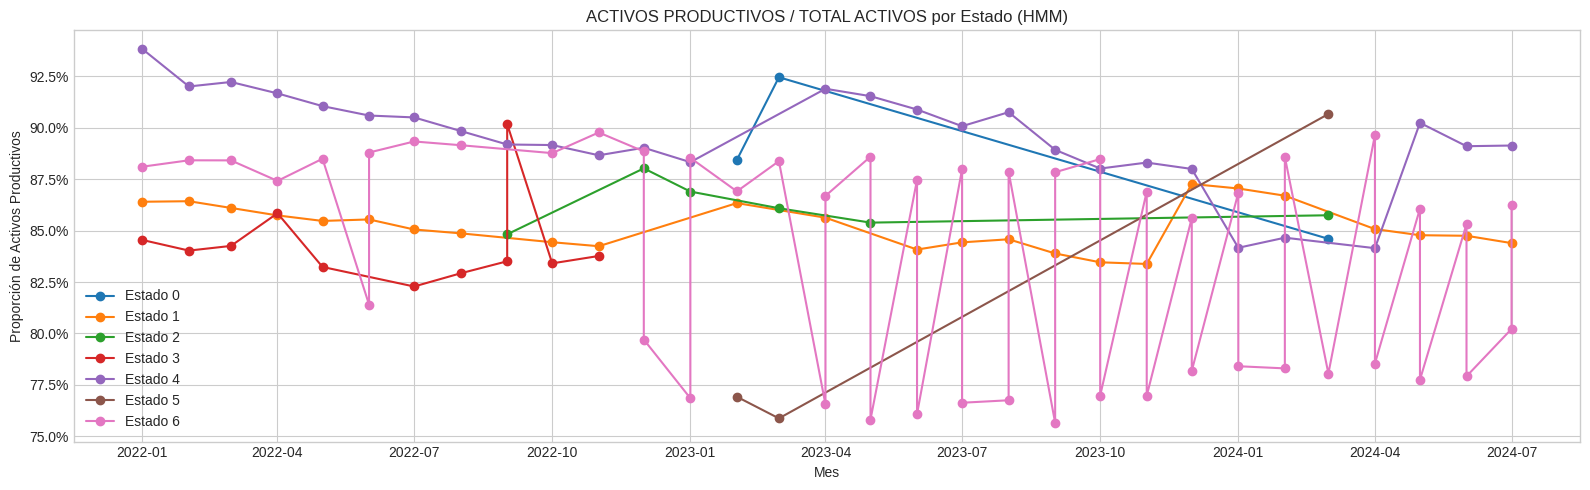

/tmp/ipython-input-1966668088.py:396: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Estado", y="Y_ratio", data=data, palette=palette, ax=ax, inner="quartile", cut=0)


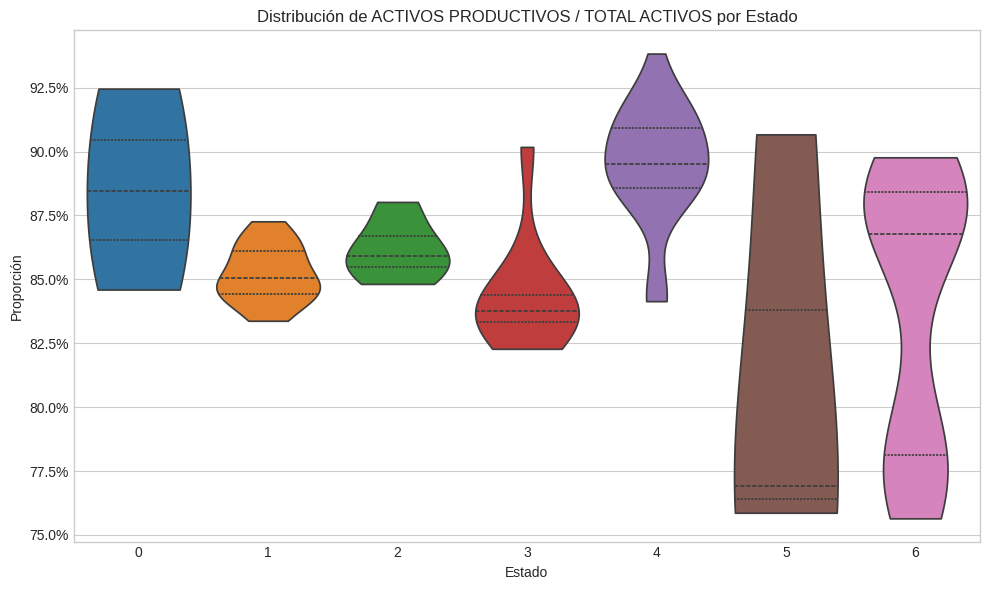

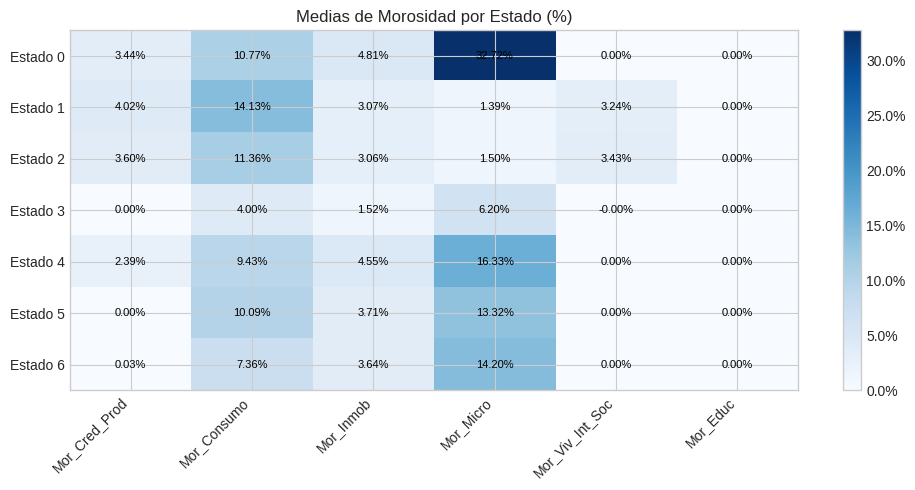

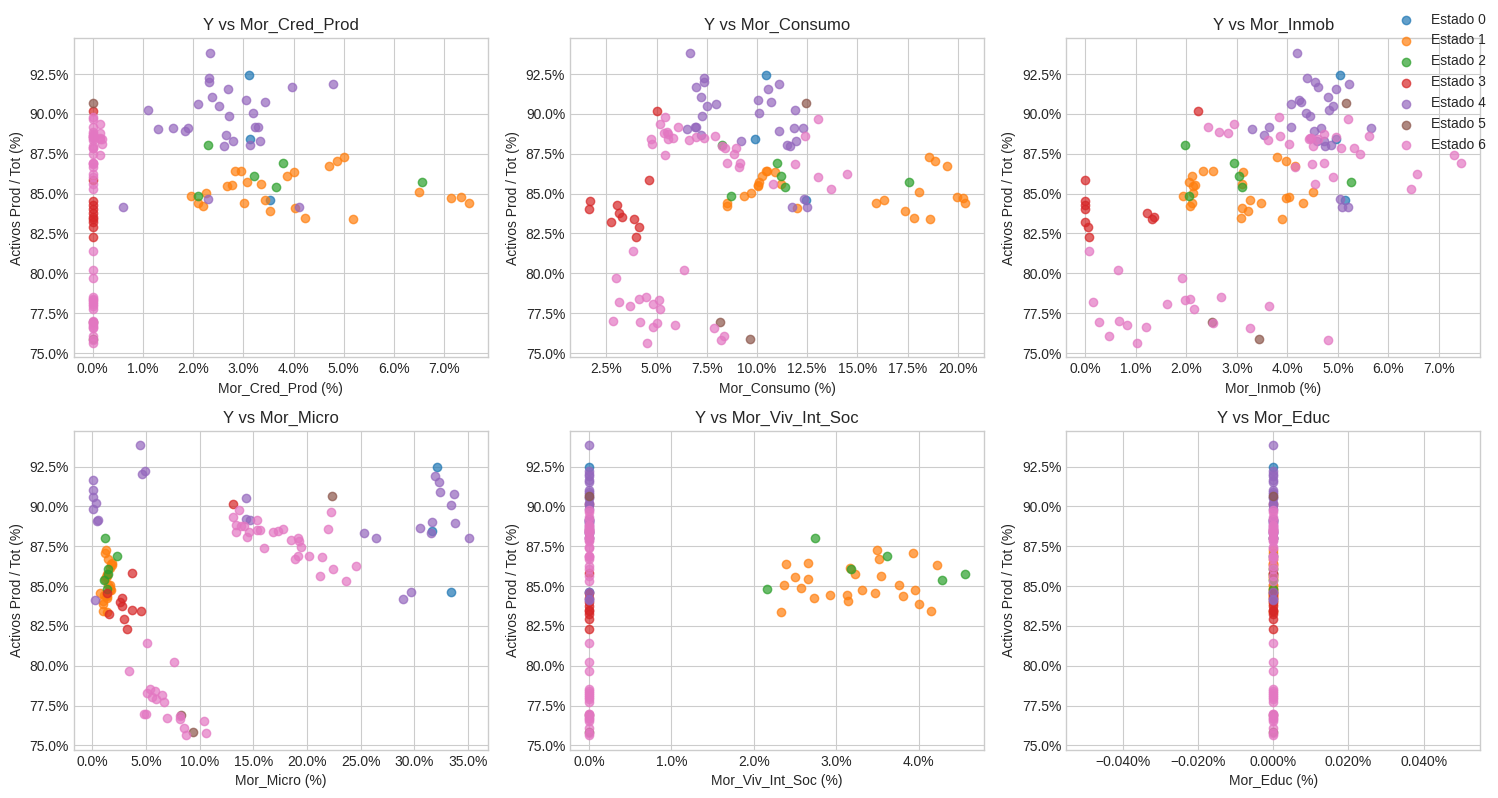

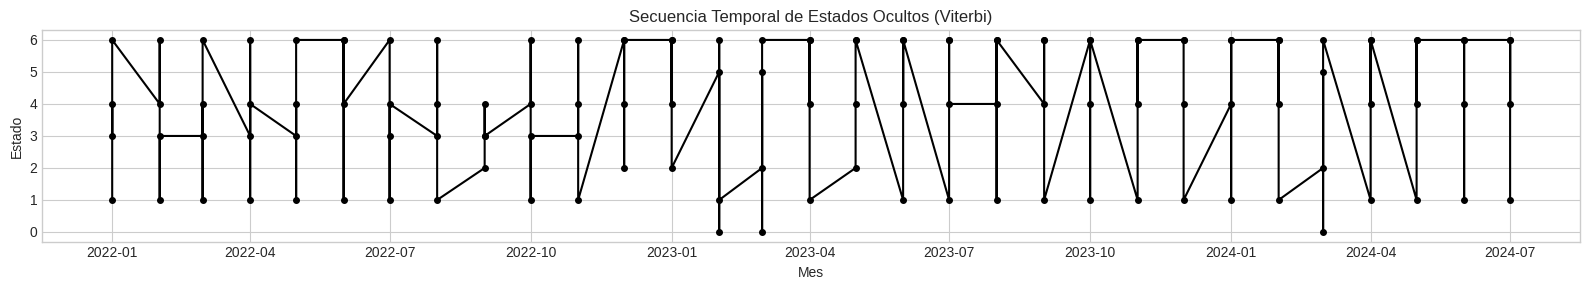

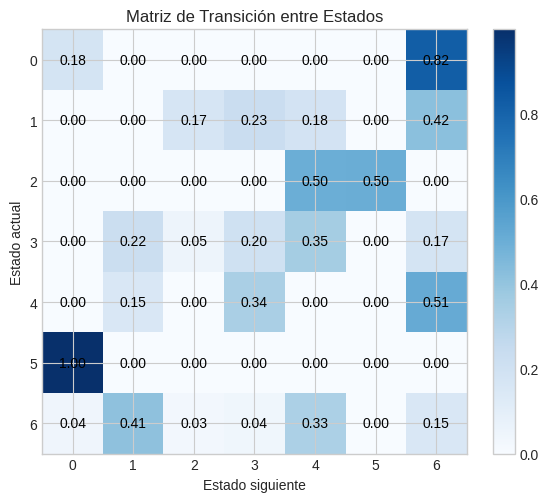

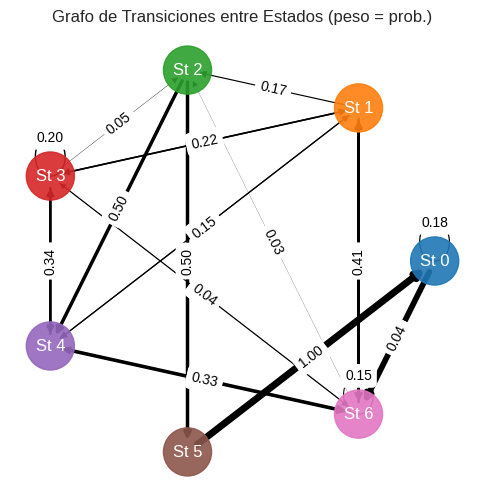

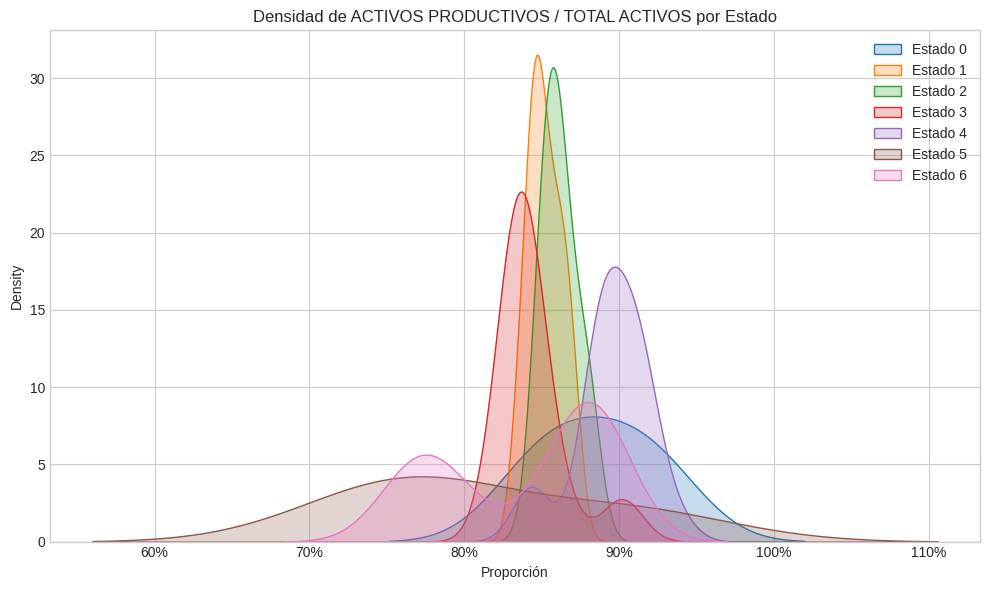


Archivo de resultados guardado en: /content/HMM_SEPS_resultados.xlsx


In [ ]:
# ============================================================
# Hidden Markov Modeling de Indicadores SEPS
# Dependiente: ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS
# Independientes: Tasas de Morosidad por Tipo de Cartera
# Autor: (auto) Alexander Fernando Haro Sarango
# Requiere: pandas, numpy, matplotlib, seaborn (opcional), hmmlearn, scipy, networkx (opcional)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

try:
    import seaborn as sns
except ImportError:
    sns = None

from hmmlearn.hmm import GaussianHMM
from scipy.special import logit, expit
from scipy.linalg import eig
from matplotlib.ticker import PercentFormatter

# ------------------------------------------------------------
# 0. Configuración de usuario
# ------------------------------------------------------------

DATA_PATH = "/content/INDICADORES SEPS - copia.xlsx"

# Si el archivo tiene varias hojas y quieres una específica:
SHEET_NAME = 0  # puede ser nombre de la hoja o índice

# Si quieres filtrar por una entidad específica (código o nombre), pon el valor; sino None
ENTIDAD_FILTRO = None  # ejemplo: "MUTUALISTA PICHINCHA"

# Diccionario de mapeo flexible de nombres de columnas a códigos cortos
# Ajusta las claves a EXACTOS encabezados en tu archivo si no coinciden.
COL_MAP = {
    "fecha": "Mes",  # se intentará detectar automáticamente entre varias alternativas
    "y_ratio": "ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS",
    "mor_prod": "MOROSIDAD DE LA CARTERA DE CREDITO PRODUCTIVO",
    "mor_cons": "MOROSIDAD DE LA CARTERA DE CONSUMO",
    "mor_inmo": "MOROSIDAD DE LA CARTERA DE CREDITO INMOBILIARIO",
    "mor_micro": "MOROSIDAD DE LA CARTERA DE MICROCREDITO",
    "mor_viv": "MOROSIDAD DE LA CARTERA DE VIVIENDA DE INTERES SOCIAL Y PUBLICO",
    "mor_edu": "MOROSIDAD DE LA CARTERA DE CREDITO EDUCATIVO",
    # opcional: identifica columna entidad si existe
    "entidad": "ENTIDAD",  # cambia si tu archivo usa otro encabezado
}

# Número máximo de estados a considerar en la búsqueda de modelo
N_STATES_CANDIDATES = range(2, 9)  # 2..8

# Semilla reproducible
RANDOM_STATE = 42

# ------------------------------------------------------------
# 1. Funciones auxiliares
# ------------------------------------------------------------

def find_date_col(df):
    """Heurística: devolver la primera columna que parezca fecha."""
    candidates = [c for c in df.columns if c.strip().lower() in ("mes", "fecha", "periodo", "period", "month", "date")]
    if candidates:
        return candidates[0]
    # fallback: intenta detectar por tipo
    for c in df.columns:
        if np.issubdtype(df[c].dtype, np.datetime64):
            return c
    # último recurso: si hay columna con formato string 'YYYY-MM' etc.
    for c in df.columns:
        try:
            pd.to_datetime(df[c], errors="raise")
            return c
        except Exception:
            pass
    raise ValueError("No se pudo detectar una columna de fecha; por favor ajusta COL_MAP['fecha'].")

def as_datetime(series):
    """Convertir una serie a datetime robustamente."""
    return pd.to_datetime(series, errors="coerce", dayfirst=False, infer_datetime_format=True)

def pct_to_prop(s):
    """Detecta si valores parecen porcentajes (e.g., 5.2) y convierte a proporción (0.052)."""
    s2 = s.astype(float)
    # si más del 90% de los valores >1, asumimos está en % y dividimos por 100
    if (s2 > 1).mean() > 0.9:
        return s2 / 100.0
    return s2

def safe_logit(p, eps=1e-6):
    """Clipping y logit estable."""
    p = np.clip(p, eps, 1 - eps)
    return logit(p)

def gaussian_hmm_n_params(n_states, n_features, covariance_type="full"):
    """
    Número de parámetros libres en GaussianHMM (aprox) p/ AIC/BIC.
    startprob: n_states-1
    transmat: n_states*(n_states-1)
    means: n_states*n_features
    covs: depende del tipo
    """
    k_start = n_states - 1
    k_trans = n_states * (n_states - 1)
    if covariance_type == "full":
        k_covs = n_states * (n_features * (n_features + 1) // 2)
    elif covariance_type == "diag":
        k_covs = n_states * n_features
    elif covariance_type == "spherical":
        k_covs = n_states
    else:  # tied
        if covariance_type == "tied":
            k_covs = (n_features * (n_features + 1) // 2)
        else:
            raise ValueError("covariance_type no soportado en conteo.")
    k_means = n_states * n_features
    return k_start + k_trans + k_means + k_covs

def fit_hmm_bic_search(X, n_states_list, covariance_type="full", n_iter=1000, random_state=RANDOM_STATE, verbose=False):
    """Entrena modelos HMM para varios números de estados y retorna tabla + mejor modelo por BIC."""
    rows = []
    best_model = None
    best_bic = np.inf
    for n_states in n_states_list:
        mdl = GaussianHMM(
            n_components=n_states,
            covariance_type=covariance_type,
            n_iter=n_iter,
            random_state=random_state,
        )
        mdl.fit(X)
        log_lik = mdl.score(X)
        k_total = gaussian_hmm_n_params(n_states, X.shape[1], covariance_type)
        aic = 2 * k_total - 2 * log_lik
        bic = np.log(len(X)) * k_total - 2 * log_lik
        rows.append((n_states, log_lik, k_total, aic, bic))
        if verbose:
            print(f"Estados={n_states} logL={log_lik:.1f} AIC={aic:.1f} BIC={bic:.1f}")
        if bic < best_bic:
            best_bic = bic
            best_model = mdl
    df_metrics = pd.DataFrame(rows, columns=["Estados", "LogLik", "Parámetros", "AIC", "BIC"])
    return best_model, df_metrics.sort_values("Estados").reset_index(drop=True)

def stationary_distribution(transmat):
    """Distribución estacionaria (vector propio asociado a λ=1)."""
    evals, evecs = eig(transmat.T)
    # busca eigenvalue más cercano a 1
    idx = np.argmin(np.abs(evals - 1))
    v = np.real(evecs[:, idx])
    v = v / v.sum()
    v = np.maximum(v, 0)  # seguridad
    return v / v.sum()

def run_lengths(states):
    """Devuelve longitudes de rachas consecutivas por estado."""
    states = np.asarray(states)
    lengths = []
    cur_state = states[0]
    cur_len = 1
    for s in states[1:]:
        if s == cur_state:
            cur_len += 1
        else:
            lengths.append((cur_state, cur_len))
            cur_state = s
            cur_len = 1
    lengths.append((cur_state, cur_len))
    return pd.DataFrame(lengths, columns=["Estado", "Longitud"])

def expected_duration(transmat):
    """Duración esperada en cada estado = 1 / (1 - Pii)."""
    p_stay = np.diag(transmat)
    return 1.0 / (1 - p_stay)

def inverse_standardize(means_std, covs_std, scaler):
    """
    Convierte medias y covarianzas estandarizadas de vuelta a escala original.
    scaler: fitted StandardScaler
    """
    means_orig = means_std * scaler.scale_ + scaler.mean_
    # cov original = S * cov_std * S, con S = diag(scale_)
    S = np.diag(scaler.scale_)
    covs_orig = np.array([S @ cov @ S for cov in covs_std])
    return means_orig, covs_orig

# ------------------------------------------------------------
# 2. Cargar datos
# ------------------------------------------------------------

df_raw = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
df = df_raw.copy()
df.columns = df.columns.str.strip()

# Detecta columna fecha si no coincide el mapeo
if COL_MAP["fecha"] not in df.columns:
    COL_MAP["fecha"] = find_date_col(df)

# Filtra entidad si aplica
if COL_MAP["entidad"] in df.columns and ENTIDAD_FILTRO is not None:
    df = df[df[COL_MAP["entidad"]].astype(str).str.strip().str.upper() == str(ENTIDAD_FILTRO).strip().upper()].copy()

# Convierte fecha
df["Mes"] = as_datetime(df[COL_MAP["fecha"]])
df = df.sort_values("Mes").reset_index(drop=True)

# Selecciona columnas de interés
cols_needed = [
    COL_MAP["y_ratio"],
    COL_MAP["mor_prod"],
    COL_MAP["mor_cons"],
    COL_MAP["mor_inmo"],
    COL_MAP["mor_micro"],
    COL_MAP["mor_viv"],
    COL_MAP["mor_edu"],
]
missing = [c for c in cols_needed if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el archivo: {missing}")

data = df[["Mes"] + cols_needed].copy()

# ------------------------------------------------------------
# 3. Conversión a numérico y limpieza
# ------------------------------------------------------------

for c in cols_needed:
    data[c] = pd.to_numeric(data[c], errors="coerce")

# Quita filas sin fecha o sin total de datos
data = data.dropna(subset=["Mes"]).reset_index(drop=True)

# Limpieza de extremos y nulos: permite NA en independientes; se imputan luego
# Si prefieres eliminar filas con NA en cualquier columna, descomenta:
# data = data.dropna().reset_index(drop=True)

# ------------------------------------------------------------
# 4. Transformaciones de escala
# ------------------------------------------------------------
# Detecta % y convierte a proporción en todas las morosidades y en Y (si aplica)

for c in cols_needed:
    data[c] = pct_to_prop(data[c])

# Asigna nombres cortos / renombra para trabajo interno
REN = {
    COL_MAP["y_ratio"]: "Y_ratio",
    COL_MAP["mor_prod"]: "Mor_Cred_Prod",
    COL_MAP["mor_cons"]: "Mor_Consumo",
    COL_MAP["mor_inmo"]: "Mor_Inmob",
    COL_MAP["mor_micro"]: "Mor_Micro",
    COL_MAP["mor_viv"]: "Mor_Viv_Int_Soc",
    COL_MAP["mor_edu"]: "Mor_Educ",
}
data = data.rename(columns=REN)

# Variable dependiente (proporción); aplica logit para suavizar límites
data["Y_logit"] = safe_logit(data["Y_ratio"])

# Feature matrix: elegimos incluir **la variable dependiente transformada + todas las morosidades**.
# Nota: puedes excluir Y de las features si prefieres modelar solo sobre X y luego analizar Y por estado.
USE_Y_IN_X = True
if USE_Y_IN_X:
    feature_cols = ["Y_logit", "Mor_Cred_Prod", "Mor_Consumo", "Mor_Inmob", "Mor_Micro", "Mor_Viv_Int_Soc", "Mor_Educ"]
else:
    feature_cols = ["Mor_Cred_Prod", "Mor_Consumo", "Mor_Inmob", "Mor_Micro", "Mor_Viv_Int_Soc", "Mor_Educ"]

# Drop filas con NA en features
data = data.dropna(subset=feature_cols).reset_index(drop=True)

# ------------------------------------------------------------
# 5. Escalamiento (StandardScaler)
# ------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(data[feature_cols].values)

# ------------------------------------------------------------
# 6. Selección de número de estados
# ------------------------------------------------------------
best_model, metrics_grid = fit_hmm_bic_search(
    X_std,
    n_states_list=N_STATES_CANDIDATES,
    covariance_type="full",
    n_iter=1000,
    random_state=RANDOM_STATE,
    verbose=True,
)

print("\n=== Comparación de modelos por número de estados ===")
print(metrics_grid.to_string(index=False))

n_states_best = best_model.n_components
print(f"\nMejor modelo por BIC: {n_states_best} estados.")

# ------------------------------------------------------------
# 7. Decodificación con el mejor modelo
# ------------------------------------------------------------
hidden_states = best_model.predict(X_std)              # Viterbi
posteriors = best_model.predict_proba(X_std)           # gamma_t(i)

data["Estado"] = hidden_states

# ------------------------------------------------------------
# 8. Tablas resumen del modelo
# ------------------------------------------------------------

# Parámetros en escala estándar
means_std = best_model.means_
covs_std = best_model.covars_

# Reversión a escala original
means_orig, covs_orig = inverse_standardize(means_std, covs_std, scaler)

# Distribución estacionaria (teórica)
pi_stat = stationary_distribution(best_model.transmat_)

# Duración esperada
dur_exp = expected_duration(best_model.transmat_)

# Frecuencia empírica observada
freq_emp = pd.Series(hidden_states).value_counts().sort_index()
freq_emp_pct = freq_emp / len(hidden_states)

# Tabla parámetros (escala estándar)
param_std_df = (
    pd.DataFrame(means_std, columns=[f"μ_{c}" for c in feature_cols])
    .assign(**{f"Var_{c}": covs_std[:, i, i] for i, c in enumerate(feature_cols)})
    .assign(Prob_Inicial=best_model.startprob_)
)
param_std_df.index = [f"Estado {i}" for i in range(n_states_best)]

# Tabla parámetros (escala original) – recordando que Y está en logit en X_std; convertimos a proporción
param_orig_df = pd.DataFrame(means_orig, columns=[f"μ_{c}_orig" for c in feature_cols])
for i, c in enumerate(feature_cols):
    param_orig_df[f"Var_{c}_orig"] = covs_orig[:, i, i]

# Si usamos Y_logit como feature, agrega columna invertida (expit) para interpretación
if USE_Y_IN_X:
    param_orig_df["μ_Y_ratio_est"] = expit(param_orig_df["μ_Y_logit_orig"])

param_orig_df["Prob_Inicial"] = best_model.startprob_
param_orig_df["Prob_Estacionaria"] = pi_stat
param_orig_df["Dur_Esp(E[long])"] = dur_exp
param_orig_df["Freq_Empírica"] = freq_emp.values
param_orig_df["Freq_Empírica_%"] = freq_emp_pct.values * 100
param_orig_df.index = [f"Estado {i}" for i in range(n_states_best)]

print("\n=== Parámetros por estado (escala estándar) ===")
print(param_std_df.round(4).to_string())

print("\n=== Parámetros por estado (escala original) ===")
print(param_orig_df.round(6).to_string())

# ------------------------------------------------------------
# 9. Análisis de rachas
# ------------------------------------------------------------
rl = run_lengths(hidden_states)
rl_summary = rl.groupby("Estado")["Longitud"].describe()
print("\n=== Longitud de rachas (observada) por estado ===")
print(rl_summary.round(2).to_string())

# ------------------------------------------------------------
# 10. Visualizaciones
# ------------------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid") if sns is not None else None

# Paleta
if sns is not None:
    palette = sns.color_palette("tab10", n_states_best)
else:
    cmap = plt.cm.get_cmap("tab10", n_states_best)
    palette = [cmap(i) for i in range(n_states_best)]

# --- 10.1 Serie temporal de Y_ratio coloreada por estado ---
fig, ax = plt.subplots(figsize=(16, 5))
for i in range(n_states_best):
    idx = data["Estado"] == i
    ax.plot(data.loc[idx, "Mes"], data.loc[idx, "Y_ratio"], marker='o', linestyle='-', label=f"Estado {i}", color=palette[i])
ax.set_title("ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS por Estado (HMM)")
ax.set_xlabel("Mes")
ax.set_ylabel("Proporción de Activos Productivos")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.legend()
plt.tight_layout()
plt.show()

# --- 10.2 Box/Violin de Y_ratio por estado ---
fig, ax = plt.subplots(figsize=(10, 6))
if sns is not None:
    sns.violinplot(x="Estado", y="Y_ratio", data=data, palette=palette, ax=ax, inner="quartile", cut=0)
else:
    ax.boxplot([data.loc[data["Estado"] == i, "Y_ratio"] for i in range(n_states_best)])
ax.set_title("Distribución de ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS por Estado")
ax.set_ylabel("Proporción")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# --- 10.3 Heatmap de medias de morosidad por estado (escala original %)
mor_cols = ["Mor_Cred_Prod", "Mor_Consumo", "Mor_Inmob", "Mor_Micro", "Mor_Viv_Int_Soc", "Mor_Educ"]
if USE_Y_IN_X:
    # en param_orig_df, col prefijo μ_...
    mu_moros = param_orig_df[[f"μ_{c}_orig" for c in feature_cols if c in mor_cols]].copy()
else:
    mu_moros = param_orig_df[[f"μ_{c}_orig" for c in mor_cols]].copy()

# Renombra limpio
mu_moros.columns = [c.replace("μ_", "").replace("_orig", "") for c in mu_moros.columns]
# Convertir a % (asumiendo proporción)
mu_moros_pct = mu_moros * 100

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(mu_moros_pct.values, cmap="Blues", aspect="auto")
ax.set_title("Medias de Morosidad por Estado (%)")
ax.set_xticks(range(mu_moros_pct.shape[1]))
ax.set_xticklabels(mu_moros_pct.columns, rotation=45, ha="right")
ax.set_yticks(range(n_states_best))
ax.set_yticklabels([f"Estado {i}" for i in range(n_states_best)])
plt.colorbar(im, ax=ax, format="%.1f%%")
# anotaciones
for i in range(n_states_best):
    for j in range(mu_moros_pct.shape[1]):
        ax.text(j, i, f"{mu_moros_pct.iloc[i, j]:.2f}%", ha="center", va="center", color="black", fontsize=8)
plt.tight_layout()
plt.show()

# --- 10.4 Scatter Y_ratio vs cada morosidad (paneles) ---
n_m = len(mor_cols)
ncols = 3
nrows = int(np.ceil(n_m / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows), sharex=False, sharey=False)
axes = axes.flatten()

for k, c in enumerate(mor_cols):
    ax = axes[k]
    for i in range(n_states_best):
        idx = data["Estado"] == i
        ax.scatter(data.loc[idx, c]*100, data.loc[idx, "Y_ratio"]*100, label=f"Estado {i}", alpha=0.7, color=palette[i])
    ax.set_xlabel(f"{c} (%)")
    ax.set_ylabel("Activos Prod / Tot (%)")
    ax.set_title(f"Y vs {c}")
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))
    ax.xaxis.set_major_formatter(PercentFormatter(100.0))
if n_m < len(axes):  # borra ejes sobrantes
    for ax in axes[n_m:]:
        ax.axis("off")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

# --- 10.5 Secuencia temporal de estados ---
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(data["Mes"], data["Estado"], marker='o', linestyle='-', markersize=4, color="black")
ax.set_title("Secuencia Temporal de Estados Ocultos (Viterbi)")
ax.set_xlabel("Mes")
ax.set_ylabel("Estado")
ax.set_yticks(range(n_states_best))
plt.tight_layout()
plt.show()

# --- 10.6 Matriz de transición ---
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(best_model.transmat_, cmap="Blues", vmin=0, vmax=best_model.transmat_.max())
ax.set_title("Matriz de Transición entre Estados")
ax.set_xlabel("Estado siguiente")
ax.set_ylabel("Estado actual")
ax.set_xticks(range(n_states_best))
ax.set_yticks(range(n_states_best))
plt.colorbar(im, ax=ax)
# anotaciones
for i in range(n_states_best):
    for j in range(n_states_best):
        ax.text(j, i, f"{best_model.transmat_[i, j]:.2f}", ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

# --- 10.7 Grafo de transiciones (opcional) ---
try:
    import networkx as nx
    G = nx.DiGraph()
    for i in range(n_states_best):
        G.add_node(i)
    for i in range(n_states_best):
        for j in range(n_states_best):
            w = best_model.transmat_[i, j]
            if w > 0.01:  # filtra transiciones muy pequeñas
                G.add_edge(i, j, weight=w, label=f"{w:.2f}")
    pos = nx.circular_layout(G)
    plt.figure(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color=palette, alpha=0.9)
    nx.draw_networkx_labels(G, pos, labels={i: f"St {i}" for i in G.nodes}, font_color="white")
    widths = [G[u][v]['weight'] * 5 for u, v in G.edges]  # escala
    nx.draw_networkx_edges(G, pos, width=widths, arrows=True, arrowstyle='-|>')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges})
    plt.title("Grafo de Transiciones entre Estados (peso = prob.)")
    plt.axis("off")
    plt.show()
except ImportError:
    print("networkx no disponible; se omite grafo de transiciones.")

# --- 10.8 Densidad de Y_ratio por estado ---
if sns is not None:
    plt.figure(figsize=(10, 6))
    for i in range(n_states_best):
        sns.kdeplot(data.loc[data["Estado"] == i, "Y_ratio"], label=f"Estado {i}", fill=True, common_norm=False)
    plt.title("Densidad de ACTIVOS PRODUCTIVOS / TOTAL ACTIVOS por Estado")
    plt.xlabel("Proporción")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 11. Exportar resultados a Excel
# ------------------------------------------------------------

OUT_PATH = Path("/content/HMM_SEPS_resultados.xlsx")
with pd.ExcelWriter(OUT_PATH, engine="xlsxwriter") as writer:
    data.to_excel(writer, sheet_name="Datos_con_Estados", index=False)
    metrics_grid.to_excel(writer, sheet_name="Selección_Estados", index=False)
    param_std_df.round(6).to_excel(writer, sheet_name="Params_EscalaStd")
    param_orig_df.round(6).to_excel(writer, sheet_name="Params_EscalaOrig")
    rl.to_excel(writer, sheet_name="Rachas", index=False)
    rl_summary.round(4).to_excel(writer, sheet_name="Rachas_Resumen")

print(f"\nArchivo de resultados guardado en: {OUT_PATH}")


In [ ]:
# ============================================================
# 12. Normality and distribution diagnostics (exploratory)
# ============================================================

from scipy.stats import skew, kurtosis, normaltest

print("\n=== Normality diagnostics for transformed features (full sample) ===")
diag_rows = []
for c in feature_cols:
    x = X_std[:, feature_cols.index(c)]
    # D'Agostino-Pearson test (requires n >= 20, here satisfied)
    stat, pval = normaltest(x)
    diag_rows.append((c, np.mean(x), np.std(x), skew(x), kurtosis(x), pval))

diag_df = pd.DataFrame(
    diag_rows,
    columns=["Feature", "Mean", "Std", "Skewness", "Kurtosis", "Normaltest_pval"]
)

print(diag_df.round(4).to_string(index=False))

# Nota para el paper:
# "Basic diagnostics on the standardized features indicate approximate symmetry
# and acceptable deviations from normality for an exploratory Gaussian HMM,
# though heavier tails in stress periods remain a limitation."

# Opcional: guardar en el Excel existente
with pd.ExcelWriter(OUT_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    diag_df.round(6).to_excel(writer, sheet_name="Normality_Diagnostics", index=False)


# ============================================================
# 13. Latent state summary & economic interpretation helper
# ============================================================

# Construir una tabla compacta para interpretar cada estado
state_summary = pd.DataFrame({
    "State": [f"State {i}" for i in range(n_states_best)],
    "Mean_PATR": param_orig_df["μ_Y_ratio_est"] if "μ_Y_ratio_est" in param_orig_df.columns else np.nan,
    "Freq_Empirical_%": param_orig_df["Freq_Empírica_%"],
    "Expected_Duration": param_orig_df["Dur_Esp(E[long])"],
    "Stationary_Prob": param_orig_df["Prob_Estacionaria"]
})

# Añadimos medias de morosidad por estado (en %)
for col in ["Mor_Cred_Prod", "Mor_Consumo", "Mor_Inmob", "Mor_Micro", "Mor_Viv_Int_Soc", "Mor_Educ"]:
    mu_col = f"μ_{col}_orig"
    if mu_col in param_orig_df.columns:
        state_summary[f"Mean_{col}_%"] = param_orig_df[mu_col] * 100

# Columna vacía para que tú asignes la etiqueta conceptual en el paper
state_summary["Suggested_Label"] = ""

print("\n=== Latent State Summary (use this to define economic labels in the paper) ===")
print(state_summary.round(4).to_string(index=False))

# Guardar en Excel como insumo para tablas del manuscrito/anexos
with pd.ExcelWriter(OUT_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    state_summary.round(6).to_excel(writer, sheet_name="State_Summary", index=False)


# ============================================================
# 14. Alternative specifications: diagonal covariance robustness
# ============================================================

def fit_hmm_bic_search_cov(X, n_states_list, covariance_type, label, n_iter=1000, random_state=RANDOM_STATE):
    rows = []
    best_model_loc = None
    best_bic_loc = np.inf
    for n_states in n_states_list:
        mdl = GaussianHMM(
            n_components=n_states,
            covariance_type=covariance_type,
            n_iter=n_iter,
            random_state=random_state,
        )
        mdl.fit(X)
        log_lik = mdl.score(X)
        k_total = gaussian_hmm_n_params(n_states, X.shape[1], covariance_type)
        aic = 2 * k_total - 2 * log_lik
        bic = np.log(len(X)) * k_total - 2 * log_lik
        rows.append((label, n_states, log_lik, k_total, aic, bic))
        if bic < best_bic_loc:
            best_bic_loc = bic
            best_model_loc = mdl
    return best_model_loc, pd.DataFrame(
        rows,
        columns=["Spec", "States", "LogLik", "Parameters", "AIC", "BIC"]
    )

# Comparar especificación original (full) con diagonal como robustez
_, metrics_diag = fit_hmm_bic_search_cov(
    X_std,
    n_states_list=N_STATES_CANDIDATES,
    covariance_type="diag",
    label="diag"
)

metrics_full = metrics_grid.copy()
metrics_full.insert(0, "Spec", "full")

metrics_both = pd.concat([metrics_full, metrics_diag], ignore_index=True)

print("\n=== Model selection: full vs diagonal covariance (robustness) ===")
print(metrics_both.round(2).to_string(index=False))

# Guardar para anexos
with pd.ExcelWriter(OUT_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    metrics_both.round(6).to_excel(writer, sheet_name="Model_Selection_Full_vs_Diag", index=False)

# Nota para el paper:
# "We also estimated diagonal-covariance HMMs as a parsimonious alternative.
# The preferred seven-state specification under full covariance is supported by BIC,
# and key qualitative patterns are robust across specifications."


# ============================================================
# 15. Jackknife robustness by institution (if entity column available)
# ============================================================

if COL_MAP["entidad"] in df_raw.columns:
    print("\n=== Jackknife robustness by excluding one mutualist at a time ===")
    ent_col = COL_MAP["entidad"]
    entities = sorted(df_raw[ent_col].dropna().unique())

    jk_results = []

    for ent in entities:
        # Filtrar fuera esta entidad
        df_jk = df_raw[df_raw[ent_col] != ent].copy()
        df_jk.columns = df_jk.columns.str.strip()

        # Detectar columna de fecha nuevamente si es necesario
        date_col = COL_MAP["fecha"]
        if date_col not in df_jk.columns:
            try:
                date_col = find_date_col(df_jk)
            except Exception:
                print(f"  [Skip] Could not detect date column for jackknife excluding {ent}")
                continue

        df_jk["Mes"] = as_datetime(df_jk[date_col])
        df_jk = df_jk.sort_values("Mes").reset_index(drop=True)

        # Construir matriz de features igual que en la especificación principal
        jk_missing = [c for c in cols_needed if c not in df_jk.columns]
        if jk_missing:
            print(f"  [Skip] Missing columns {jk_missing} when excluding {ent}")
            continue

        data_jk = df_jk[["Mes"] + cols_needed].copy()
        for c in cols_needed:
            data_jk[c] = pd.to_numeric(data_jk[c], errors="coerce")
            data_jk[c] = pct_to_prop(data_jk[c])

        data_jk = data_jk.rename(columns=REN)
        if USE_Y_IN_X:
            data_jk["Y_logit"] = safe_logit(data_jk["Y_ratio"])
            jk_feature_cols = ["Y_logit", "Mor_Cred_Prod", "Mor_Consumo",
                               "Mor_Inmob", "Mor_Micro", "Mor_Viv_Int_Soc", "Mor_Educ"]
        else:
            jk_feature_cols = ["Mor_Cred_Prod", "Mor_Consumo",
                               "Mor_Inmob", "Mor_Micro", "Mor_Viv_Int_Soc", "Mor_Educ"]

        data_jk = data_jk.dropna(subset=jk_feature_cols).reset_index(drop=True)
        if len(data_jk) < 10:
            print(f"  [Skip] Too few observations when excluding {ent}")
            continue

        scaler_jk = StandardScaler()
        X_jk = scaler_jk.fit_transform(data_jk[jk_feature_cols].values)

        # Seleccionar modelo por BIC con las mismas reglas
        best_jk_model, jk_metrics = fit_hmm_bic_search(
            X_jk,
            n_states_list=N_STATES_CANDIDATES,
            covariance_type="full",
            n_iter=1000,
            random_state=RANDOM_STATE,
            verbose=False,
        )

        n_best_jk = best_jk_model.n_components
        jk_results.append({
            "Excluded_Entity": str(ent),
            "Best_States": n_best_jk,
            "Best_BIC": float(jk_metrics.loc[jk_metrics["Estados"] == n_best_jk, "BIC"].iloc[0])
        })

        print(f"  Excluding {ent}: best model = {n_best_jk} states (by BIC)")

    if jk_results:
        jk_df = pd.DataFrame(jk_results)
        print("\nJackknife summary:")
        print(jk_df.to_string(index=False))

        with pd.ExcelWriter(OUT_PATH, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            jk_df.to_excel(writer, sheet_name="Jackknife_Mutuals", index=False)

        # Nota para el paper:
        # "We perform a jackknife robustness check by re-estimating the model
        # excluding one mutualist at a time. The preferred number of regimes
        # and the qualitative pattern of high- vs low-solvency states remain
        # stable, indicating that results are not driven by a single institution."
    else:
        print("No valid jackknife results could be computed; please verify entity and data structure.")
else:
    print("\n[Info] No entity column available; jackknife robustness by institution is skipped.")

# ============================================================
# Fin de extensiones para robustez y claridad de resultados
# ============================================================



=== Normality diagnostics for transformed features (full sample) ===
        Feature  Mean  Std  Skewness  Kurtosis  Normaltest_pval
        Y_logit   0.0  1.0   -0.2290   -0.3248           0.4570
  Mor_Cred_Prod   0.0  1.0    0.9394    0.2047           0.0003
    Mor_Consumo   0.0  1.0    0.7274    0.1239           0.0054
      Mor_Inmob  -0.0  1.0   -0.3655   -0.4400           0.1376
      Mor_Micro  -0.0  1.0    0.8206   -0.5937           0.0005
Mor_Viv_Int_Soc  -0.0  1.0    1.3226   -0.0133           0.0000
       Mor_Educ   0.0  0.0       NaN       NaN              NaN

=== Latent State Summary (use this to define economic labels in the paper) ===
  State  Mean_PATR  Freq_Empirical_%  Expected_Duration  Stationary_Prob  Mean_Mor_Cred_Prod_%  Mean_Mor_Consumo_%  Mean_Mor_Inmob_%  Mean_Mor_Micro_%  Mean_Mor_Viv_Int_Soc_%  Mean_Mor_Educ_% Suggested_Label
State 0     0.8979            2.4194             1.2152           0.0459                3.4440             10.7707            4.81